[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](http://colab.research.google.com/github/sk-classroom/asc-transformers/blob/main/exercise/exercise_01.ipynb)

![](https://cdn.britannica.com/03/134503-050-060DD73F/Bombe-American-version-messages-cipher-machines-Britain.jpg)

In this notebook, we will be creating a seq2seq model for deciphering a simple cipher. 
References: 
- [Sequence to Sequence Learning with Neural Networks](https://arxiv.org/abs/1409.3215)
- [Neural Machine Translation by Jointly Learning to Align and Translate](https://arxiv.org/abs/1409.0473)

# Preparation

In [1]:
# If you are using Google Colab or local environments, install the following packages:
#!pip install spacy
#!pip install torchtext

In [2]:
# Let's import the necessary packages
import torch
import numpy as np
from scipy import linalg, sparse
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Some useful functions for the implementation 

![](https://miro.medium.com/v2/resize:fit:880/1*WbLIc4-xIOfHiO2oWzimyA.png)


Tensor is at the heart of PyTorch. It is a high dimensional array that can be used to represent data. 

### Permutation 

Permutation is a common operator that swaps the dimensions of a tensor. For instance, consider the following tensor of size <10 x 5 x 20>. By permuting the dimensions, we can change the shape of the tensor to <5 x 10 x 20>. 

In [3]:
import torch

a = torch.rand((10, 5, 20))
b = a.permute(
    1, 0, 2
)  # we will create a new tensor b that takes the second dimension of a as the first dimension, the first dimension of a as the second dimension, and the third dimension of a as the third dimension.

print("Shape of original tensor:", a.shape)
print("Shape of permuted tensor:", b.shape)

Shape of original tensor: torch.Size([10, 5, 20])
Shape of permuted tensor: torch.Size([5, 10, 20])


## Squeeze and Unsqueeze

A 2d tensor can be represented as a 3d tensor, with an additional dimension containing one layer, and vise versa. For example, a 2d tensor of size <10 x 5> can be represented as a 3d tensor of size <10 x 5 x 1>.  `squeeze` and `unsqueeze` is useful to add/remove dimensions to/from a tensor.  


In [4]:
a = torch.rand((10, 5))

b = a.unsqueeze(1)  # we will insert a new dimension at 1.

print("Shape of original tensor:", a.shape)
print("Shape of unsqueezed tensor:", b.shape)

Shape of original tensor: torch.Size([10, 5])
Shape of unsqueezed tensor: torch.Size([10, 1, 5])


Likewise, we can omit the dimension of size 1 by using `squeeze`. 

In [5]:
a = torch.rand((10, 5, 1))

b = a.squeeze(2)  # we will remove the dimension at 2.

print("Shape of original tensor:", a.shape)
print("Shape of squeezed tensor:", b.shape)

Shape of original tensor: torch.Size([10, 5, 1])
Shape of squeezed tensor: torch.Size([10, 5])


# Seq2Seq model

![](https://raw.githubusercontent.com/bentrevett/pytorch-seq2seq/b3cd54c72cd6e4e63f672d334c795b4fe744ef92//assets/seq2seq1.png)

## Implementation design 

The `seq2seq` model consists of `Encoder` and `Decoder`, connected by the hidden states. 
`Encoder` takes the input sequence and generates the hidden states. 
`Decoder` takes the hidden state of the last token, and generate the output sequence.  


## Encoder 

Let's implement `Encoder`. 
While [the original paper uses four-layer LSTM](https://arxiv.org/abs/1409.3215), we will cut down it to simpler encoder, namely two-layer [Gated Recurrent Unit (GRU) by Cho et al.](https://arxiv.org/pdf/1406.1078v3.pdf). GRU simplifies LTCM by omitting the cell state and produces only the hidden state. Namely, 

$$
h_{t} = \text{GRU}(x_{t}, h_{t-1})
$$

*Multi-layered* GRU means that GRU units are stacked on top of each other, where $\ell$th ($\ell \geq 2$) GRU will take $\ell-1$th GRU's hidden state as the input. For example, two-layer GRU is given by 

$$
h^{(1)}_{t} = \text{GRU}(x_{t}, h^{(1)}_{t-1}) \\
h^{(2)}_{t} = \text{GRU}(h^{(1)}_{t}, h^{(2)}_{t-1})
$$
where $h^{(\ell)}_t$ represents the hidden state for the $\ell$ th layer at the time $t$. We will then use all layer's hidden states at the end of the sequence as the inputs to the decoder. 
With PyTorch, we can easily implement the multi-layer GRU. See [the documentation](https://pytorch.org/docs/stable/generated/torch.nn.GRU.html).

Here, let's implement `Encoder` class as follows. 

**Step 1**: `Encoder` will take sequences of integer tokens, represented as a tensor of size <batch_size x max_length>, where `batch_size` is the number of sentences in a batch, and `max_length` is the maximum length of the sentences in the batch. 

**Step 2**: The integer tokens are mapped to the vectors of size `embedding_size` by using `torch.nn.Embedding`, namely
$$
z_t = \text{Embedding}(x_t)
$$
where $z_t$ is the vector representation of the token $x_t$. 

**Step 3**: A drop out is performed on $z_t$:

$$
z_t = \text{Dropout}(z_t)
$$

**Step 4**: Embedding $z_t$ will be fed into the two-layer GRUs:
$$
h^{(1)}_t = \text{GRU}(z_t, h^{(1)}_{t-1}) \\
h^{(2)}_t = \text{GRU}(h^{(1)}_t, h^{(2)}_{t-1})
$$

**Step 5**: Output the hidden states at the last sequence time $T$, namely 
$$
(h^{(1)}_T, h^{(2)}_T)
$$



In [6]:
import torch


class Encoder(torch.nn.Module):

    def __init__(
        self, input_size, embedding_size, hidden_size, n_layers=2, dropout=0.1
    ):
        """Encoder class

        Parameters
        ----------
        input_size: int
            The number of unique tokens in the input sequence
        embedding_size: int
            The dimension of the embedding vectors
        hidden_size: int
            The dimension of the hidden states
        n_layers: int
            The number of layers in the GRU
        dropout: float
            The dropout rate
        """
        super(Encoder, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.n_layers = n_layers

        # TODO:
        self.embedding = ...
        self.gru = ...
        self.dropout = ...

        # Initialize the embedding
        torch.nn.init.xavier_uniform_(self.embedding.weight)

    def forward(self, X):
        """
        Forward pass of the encoder

        Parameters
        ----------
        input_tokens: Tensor of shape <batch_size x max_length>
            The input sequence

        Return
        ------
        hidden: Tensor of shape <num_layers x batch_size x hidden_size>
            The hidden states of the last layer
        """
        # TODO
        pass


encoder = Encoder(
    input_size=30, embedding_size=16, hidden_size=56, n_layers=2, dropout=0.1
)

# test
input_tokens = torch.randint(0, 10, size=(10, 32))  # batch_size x max_length
hidden = encoder(input_tokens)  # batch_size x max_length x hidden_size

print(f"Shape of input_vecs: {input_tokens.shape}")
print(f"Shape of hidden: {hidden[0].shape}")
print(f"Shape of cell: {hidden[1].shape}")

Shape of input_vecs: torch.Size([10, 32])
Shape of hidden: torch.Size([10, 56])
Shape of cell: torch.Size([10, 56])


## Decoder 

Let's implement `Decoder`. Following the `Encoder`, we will simplify the original implementation by using two-layer GRUs. 

Based on $h^{(\ell)}_t$ and $x_t$ (we will talk about how to generate $h_0$ and $x_0$ shortly), the decoder will generate the next token $x_{t+1}$ by using the hidden states $h^{(\ell)}_{t+1}$ at $t$ as follows:
$$
\begin{align}
z_t &= \text{Dropout}(\text{Embedding}(x_t)) \\
h^{(\ell)}_{t+1} &:= \text{GRU}(z_{t}, h^{(\ell)}_{t}) \\
x_{t+1} &:= \text{Softmax}(\text{MLP}(h^{(\ell)}_{t+1}) / \tau)
\end{align}
$$
where 
- $\text{MLP}$ is a multi-layer perceptron that ouputs a vector of the number of unique tokens, 
- $\text{Softmax}$ is a softmax function, and 
- $\tau$ is a temperature parameter that controls the randomness of the output. 

Let's implement the Decoder as follows:
1. Use two-layer GRUs
2. Apply dropout to the input embedding vectors, $z_t$
4. The `forward` function should return the output from the MLP and hidden states. 

In [7]:
class Decoder(torch.nn.Module):

    def __init__(
        self,
        input_size,
        embedding_size,
        hidden_size,
        n_layers,
        output_size,
        dropout=0.1,
    ):
        """Decoder class

        Parameters
        ----------
        input_size: int
            The number of unique tokens in the input sequence
        embedding_size: int
            The dimension of the embedding vectors
        hidden_size: int
            The dimension of the hidden states
        n_layers: int
            The number of layers in the GRU
        output_size: int
            The number of unique tokens in the output sequence
        dropout: float
            The dropout rate
        """
        super(Decoder, self).__init__()
        self.hidden_size = hidden_size
        self.n_layers = n_layers
        self.output_size = output_size
        self.embedding_size = embedding_size

        # TODO
        self.dropout = ...
        self.embedding = ...
        self.gru = ...
        self.fc = ...

        # Initialize the embedding
        torch.nn.init.xavier_uniform_(self.embedding.weight)

    def forward(self, input_tokens, hidden):
        """
        Forward pass of the decoder

        Parameters
        ----------
        input_tokens: Tensor of shape <batch_size x 1>
            The input sequence
        hidden: Tensor of shape <num_layers x batch_size x hidden_size>
            The hidden states of the last layer of the encoder

        Returns
        -------
        ouput: Tensor of shape <batch_size x max_output_len x output_size>
            The output sequence
        hidden: Tensor of shape <num_layers x batch_size x hidden_size>
            The hidden states of the last layer
        """
        # TODO: Implment the forward pass
        # Hint: You will need to flatten the hidden states of different layers to feed them into the linear layer
        # To this end, use output = hidden.permute(1, 0, 2).reshape(hidden.size(1), -1)
        output = self.fc(output)
        return output, hidden


decoder = Decoder(
    input_size=30,
    embedding_size=15,
    hidden_size=56,
    n_layers=2,
    output_size=30,
    dropout=0.1,
)

inputs, hidden, cell = (
    torch.randint(0, 10, (32, 10)),
    torch.rand(2, 32, 56),
    torch.rand(2, 32, 56),
)
output, hidden = decoder(inputs, hidden)

print(f"Shape of output: {output.shape}")

Shape of output: torch.Size([32, 30])


### Seq2Seq 

Let's implement Seq2Seq model by using `Encoder` and `Decoder`. The Encoder and Decoder are connected through the hidden states generated by the `Encoder`, which acts as the summary of the input sequence and conditions the output from the `Decoder`.  
More specifically, the GRUs in the `Decoder` take the hidden state $h^{(\ell)}_{t}$ and token $z_t$. `Decoder` is conditioned at $t=0$ by the following $h^{\ell}_0$ and $x_0$:
$$
\begin{align}
h^{(\ell)}_0 &:= \text{Encoder}(x_{T}, h^{(\ell)}_{T-1}) \\
z_0 &:= \text{<sos>}
\end{align}
$$
where 
- $T$ represents the end of the input sequence, 
- $h^{(\ell)}_0$ and $z_0$ are the hidden states of all layers and the token at $t=0$, respectively, and
- `<sos>` is a special token (vector) that indicates the begining of the sequence.

#### Number of  tokens in the output sequence 

Decoder stop its operations when $x_t = \text{<eos>}$ is output, where $\text{<eos>}$ is a special token that indicates the end of the sequence. 

#### Teacher forcing 

*Teacher forcing* is a training strategy for recurrent neural networks. Without teacher forcing, Decoder generates the probabilities of the next token given the previous tokens:
$$
P(z_{t+1} \vert z_0, z_1, \ldots, z_t)
$$
With teacher forcing, we will condition `Decoder` by the ground-truth target tokens during training, namely
$$
P(z_{t+1} \vert z^*_0, z^*_1, \ldots, z^*_t)
$$
where $*$ denotes the ground-truth.  Teacher forcing is known to facilitate learning convergence. And we will use teacher forcing during training. In evaluation, we will turn off teacher forcing and let Decoder to generate the sequence.  

### Input of the seq2seq model 

The output of the seq2seq model will be a matrix of shape <batch_size x max_output_len>. Because the length of the output sequence varies, we will pad the output sequence with the padding token $\text{<pad>}$. The padding token is a special token that indicates the padding. For example, suppose we have two sequences of length 2 and 4, respectively, then the padded sequences will be 
$$
\begin{align}
\text{<sos> I am <eos>} &\rightarrow \text{<sos> I am <eos> <pad> <pad>} \\
\text{<sos> I am a student <eos>} &\rightarrow \text{<sos> I am a student <eos>}
\end{align}
$$
By padding the output sequences, we can stack the output sequences into a tensor of shape <batch_size x max_output_len>. 


In [6]:
class Seq2Seq(torch.nn.Module):

    def __init__(self, encoder, decoder, sos_token_id, eos_token_id):
        super(Seq2Seq, self).__init__()
        self.eos_token_id = eos_token_id
        self.sos_token_id = sos_token_id
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, input_tokens, max_output_len, temperature=1.0):
        """
        Forward pass of the seq2seq model

        Parameters
        ----------
        input_tokens: Tensor of shape <max_length>
            The input sequence
        max_output_len: int
            The maximum length of the output sequence

        Return
        ------
        output: Tensor of shape <batch_size x max_length x hidden_size>
            The hidden states of the last layer
        """
        hidden = self.encoder(input_tokens.unsqueeze(0))

        decoder_input = torch.ones((1, 1), dtype=torch.long) * self.sos_token_id
        generated_seqs = []
        softmax = torch.nn.Softmax(dim=0)
        decoder_hidden = hidden
        for _ in range(max_output_len):
            output, decoder_hidden = self.decoder(decoder_input, decoder_hidden)

            # Sampling the next token by using softmax
            probs = softmax(output.squeeze(0) / temperature)
            decoder_input = torch.multinomial(probs, 1)[0].item()
            generated_seqs.append(decoder_input)

            if decoder_input == self.eos_token_id:
                break

            decoder_input = torch.ones((1, 1), dtype=torch.long) * decoder_input
        return generated_seqs

    def forward_train(self, input_tokens, output_tokens):
        """Forward pass for training based on teacher forcing

        Parameters
        ----------
        input_tokens: Tensor of shape <batch_size x max_length>
            The input sequence
        output_tokens: Tensor of shape <batch_size x max_length>
            The output sequence

        Return
        ------
        output: Tensor of shape <batch_size x max_length-1 x output_size>
            The output sequence
        """
        # TODO: Implment the forward pass for training based on teacher forcing


# Example
encoder = Encoder(
    input_size=30, embedding_size=15, hidden_size=56, n_layers=2, dropout=0.1
)
decoder = Decoder(
    input_size=30,
    embedding_size=15,
    hidden_size=56,
    n_layers=2,
    output_size=30,
    dropout=0.1,
)
seq2seq = Seq2Seq(encoder, decoder, eos_token_id=1, sos_token_id=0)

# Inference
input_tokens = torch.randint(0, 10, (10,), dtype=torch.long)
print(seq2seq(input_tokens, max_output_len=10))

output_tokens = torch.randint(0, 30, (10, 20), dtype=torch.long)
input_tokens = torch.randint(0, 30, (10, 20), dtype=torch.long)
seq2seq.forward_train(input_tokens, input_tokens).shape

NameError: name 'Encoder' is not defined

# Validation

Let's validate the seq2seq model with [Caesar cipher](https://en.wikipedia.org/wiki/Caesar_cipher). 
We will generate ciphered texts to train seq2seq and see if the trained seq2seq decipher the text correctly.  

In [7]:
from secretpy import Caesar, CaesarProgressive, alphabets as al
import random
import string


def generate_random_sequences(cipher_key, cipher, n_seqs, seq_len):

    sents = []
    ciphered_sents = []
    for _ in range(n_seqs):
        sequence = "".join(random.choices(string.ascii_lowercase, k=seq_len))
        ciphered_sequence = cipher.encrypt(sequence, cipher_key, al.ENGLISH)
        # assert len(sequence) == len(ciphered_sequence)
        assert sequence == cipher.decrypt(ciphered_sequence, cipher_key)
        sents.append(sequence)
        ciphered_sents.append(ciphered_sequence)
    return ciphered_sents, sents


key = 3
plaintext = "hellow world"
cipher = CaesarProgressive()
ciphered_sents, sents = generate_random_sequences(
    cipher_key=key, cipher=cipher, n_seqs=10000, seq_len=10
)

sents[:3], ciphered_sents[:3]

(['dqxjrvoqdu', 'aeuepmhbln', 'kyxahnmkat'],
 ['gucpydxaog', 'dizkwuqlwz', 'nccgovvulf'])

Let's tokenize the sentences into integers before training the seq2seq model. 

In [10]:
from collections import defaultdict


def build_tokenizer(sents):
    vocab = sorted(list(set("".join(sents))))

    vocab.append("<sos>")  # <sos> token
    vocab.append("<eos>")  # <eos> token
    vocab.append("<unk>")  # <unk> token used to represent the unknown token

    vocab_stoi = {token: i for i, token in enumerate(vocab)}
    vocab_itos = {i: token for i, token in enumerate(vocab)}

    sos_token_id = vocab_stoi["<sos>"]
    eos_token_id = vocab_stoi["<eos>"]
    unk_token_id = vocab_stoi["<unk>"]

    # If the token is not in the vocabulary, then return the unk_token_id
    # vocab_stoi = defaultdict(lambda: unk_token_id, vocab_stoi)
    # vocab_itos = defaultdict(lambda: unk_token_id, vocab_itos)

    return {
        "stoi": vocab_stoi,
        "itos": vocab_itos,
        "sos_token_id": sos_token_id,
        "eos_token_id": eos_token_id,
        "unk_token_id": unk_token_id,
    }


def tokenize(sents, vocab):
    retval = []
    for sent in sents:
        _retval = [vocab["sos_token_id"]]
        for letter in sent:
            _retval.append(vocab["stoi"][letter])
        _retval.append(vocab["eos_token_id"])
        retval.append(_retval)

    return retval


src_vocab = build_tokenizer(ciphered_sents)
trg_vocab = build_tokenizer(sents)

src_tokenized = tokenize(ciphered_sents, src_vocab)
trg_tokenized = tokenize(sents, trg_vocab)

print(src_tokenized[1])
print(trg_tokenized[3], trg_tokenized[1])

[26, 2, 5, 10, 18, 0, 12, 25, 1, 24, 7, 27]
[26, 23, 17, 9, 3, 8, 5, 19, 24, 17, 24, 27] [26, 1, 3, 7, 14, 21, 6, 18, 19, 15, 23, 27]


Let's train! First, let's get the number of unique tokens (alphabet + special tokens) and the special tokens ids.  

In [11]:
n_src_vocab = len(src_vocab["stoi"])
n_trg_vocab = len(trg_vocab["stoi"])

src_sos_token_id = src_vocab["sos_token_id"]
src_eos_token_id = src_vocab["eos_token_id"]
trg_sos_token_id = trg_vocab["sos_token_id"]
trg_eos_token_id = trg_vocab["eos_token_id"]

Then, set up the seq2seq model.

In [12]:
encoder = Encoder(
    input_size=n_src_vocab, embedding_size=32, hidden_size=32, n_layers=2, dropout=0
)
decoder = Decoder(
    input_size=n_trg_vocab,
    embedding_size=32,
    hidden_size=32,
    n_layers=2,
    output_size=n_trg_vocab,
    dropout=0,
)
seq2seq = Seq2Seq(
    encoder, decoder, eos_token_id=trg_eos_token_id, sos_token_id=trg_sos_token_id
)

Set up the data loader. We will exploit the fact that the sequence length is fixed. 

In [13]:
dataset = torch.utils.data.TensorDataset(
    torch.tensor(src_tokenized, dtype=torch.long),
    torch.tensor(trg_tokenized, dtype=torch.long),
)
dataloader = torch.utils.data.DataLoader(
    dataset, batch_size=5012, shuffle=True, drop_last=True
)

Let's train!

In [14]:
from tqdm import tqdm

loss_func = torch.nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(seq2seq.parameters(), lr=1e-2)

loss_values = []
n_epochs = 1000

pbar = tqdm(total=n_epochs * len(dataloader))
seq2seq.train()
for _ in range(n_epochs):
    for src, trg in dataloader:
        optimizer.zero_grad()
        output = seq2seq.forward_train(src, trg)
        loss = 0
        for t in range(trg.shape[1] - 1):
            loss += loss_func(output[:, t, :], trg[:, t + 1])
        loss /= trg.shape[1]
        loss.backward()
        optimizer.step()
        loss = loss.item()
        loss_values.append(loss)
        pbar.update(1)
        pbar.set_description(f"Loss: {loss:.4f}")

pbar.close()
seq2seq.eval()

Loss: 1.6584: 100%|██████████| 1000/1000 [02:35<00:00,  6.43it/s]


Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(29, 32)
    (gru): GRU(32, 32, num_layers=2, batch_first=True)
    (dropout): Dropout(p=0, inplace=False)
  )
  (decoder): Decoder(
    (dropout): Dropout(p=0, inplace=False)
    (embedding): Embedding(29, 32)
    (gru): GRU(32, 32, num_layers=2, batch_first=True)
    (fc): Sequential(
      (0): Linear(in_features=64, out_features=64, bias=True)
      (1): ReLU()
      (2): Dropout(p=0, inplace=False)
      (3): Linear(in_features=64, out_features=29, bias=True)
    )
    (softmax): Softmax(dim=2)
  )
)

Text(0.5, 1.0, 'Training Loss Over Time')

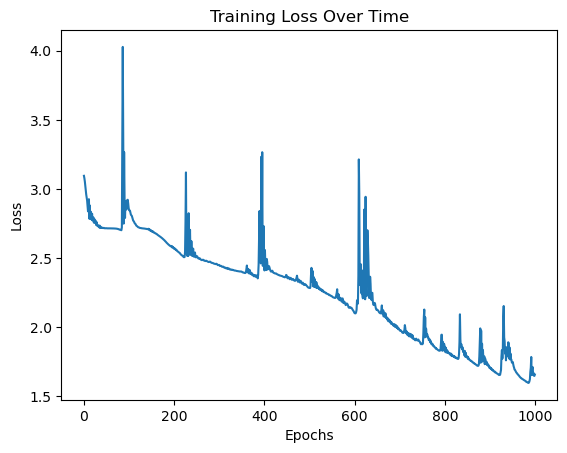

In [15]:
import matplotlib.pyplot as plt

plt.plot(loss_values)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Loss Over Time")

Can you decipher?

In [19]:
# text = "iamastudent"
for i in range(10):
    text = sents[i]
    ciphered_text = cipher.encrypt(text, key)
    ciphered_text_tokenized = torch.tensor(tokenize([ciphered_text], src_vocab))
    seqs = seq2seq(
        ciphered_text_tokenized.squeeze(0), max_output_len=10, temperature=0.01
    )

    deciphered_text = "".join([trg_vocab["itos"][i] for i in seqs])

    print("Original-Deciphered:", text, " <--> ", deciphered_text)

Original-Deciphered: icwmeuxgpo  <-->  icwleluugk
Original-Deciphered: bdhovgstpx  <-->  bdjqetluex
Original-Deciphered: fvjrkjzbhy  <-->  fvjyiykffy
Original-Deciphered: xrjdiftyry  <-->  xrjdiykfey
Original-Deciphered: fxjjsgurzm  <-->  fxjiidkgum
Original-Deciphered: xotuxlolem  <-->  xotottluam
Original-Deciphered: dyfmriepyd  <-->  dyfugakugd
Original-Deciphered: sdmshpktiw  <-->  sdmttkuufw
Original-Deciphered: zbzkheqhjg  <-->  zbhlfahgfg
Original-Deciphered: josikmicsk  <-->  josjyykgfk
